# 2.  Analyzing the Data

Use the data found on Canvas, in <b>'proshares analysis data.xlsx'</b>. 

It has monthly data on financial indexes and ETFs from `Aug 2011` through `Sep 2024`.

In [7]:
from functools import lru_cache
from operator import index
import pandas as pd
import polars as pl
import numpy as np
import pyexcel
from adodbapi.apibase import DateTime
from numpy import dtype
import statsmodels.api as sm
import polars_ols as pls
from numpy.lib.recfunctions import rename_fields

In [115]:
#Custom Functions for Polars
def Portfolio_Statistics(excess_returns: pl.dataframe,annual_factor: int | float)->pl.dataframe:
    "Takes in Excess Return Dataframe and Returns Portfolio Statistics-Polars where index isn't a thing"
    #excess_returns = excess_returns.lazy()
    excess_returns = excess_returns.select(pl.exclude(pl.Date))
    
    #This function should be used for new columns that do not rely on other columns
    summarized_stats = (
        excess_returns.select(
            mean = pl.struct(pl.all().mean()*annual_factor),
            std = pl.struct(pl.all().std()*np.sqrt(annual_factor)),
            skew = pl.struct(pl.all().skew()),
            kurtosis = pl.struct(pl.all().kurtosis(fisher = False)),
            VaR = pl.struct(pl.all().quantile(.05)),
            cVaR = pl.struct([ pl.col(col).filter(pl.col(col) <= pl.col(col).quantile(0.05)).mean()
        for col in excess_returns.columns])
            
        )
        .unpivot()
        .unnest("value")
        .unpivot(index="variable", variable_name="Index")
        #.collect()
        .pivot("variable",index="Index")
    )
    
    #This part should be used for functions that rely on other columns
    
    summarized_stats_final = (
        summarized_stats.with_columns(
            (pl.col('mean') / pl.col('std')) .alias('sharpe'),
            ()
    
    )
    
    )
    
    summarized_stats_final = summarized_stats_final.select(pl.exclude('literal'))

    return summarized_stats_final
    

def Drawdown_Statistics(returns: pl.DataFrame) -> pl.DataFrame:
    """
    Take in a return stream of data for multiple stocks and return a dataframe
    with details about max, min drawdowns with 'Date' column.
    """

    # Unpivot to long format (if not already) to work on individual stock-level data
    returns = returns.unpivot(index='Date', value_name='Returns', variable_name='Stock')    
    
    # Sort the DataFrame by Stock and Date for cumulative calculations
    returns = returns.sort(by="Date")

 # Step 1: Calculate cumulative returns using cum_prod
    returns = returns.with_columns(
        (1 + pl.col("Returns")).cum_prod().over("Stock").alias("Cumulative_Returns")
    )
    
    # Step 2: Calculate the rolling maximum of cumulative returns using cum_max
    returns = returns.with_columns(
        pl.col("Cumulative_Returns").cum_max().over("Stock").alias("Rolling_Max")
    )
    
    # Step 3: Calculate drawdown as (Rolling_Max - Cumulative_Returns) / Rolling_Max
    returns = returns.with_columns(
        ((pl.col("Cumulative_Returns") - pl.col("Rolling_Max")) / pl.col("Rolling_Max")).alias("Drawdown")
    )

    # Step 4: Calculate max drawdown and its corresponding bottom date for each stock
    max_drawdown_df = returns.group_by("Stock").agg([
        pl.col("Drawdown").min().alias("Max_Drawdown"),
        pl.col("Date").filter(pl.col("Drawdown") == pl.col("Drawdown").min()).first().alias("Bottom")
    ])
    
    # Join max_drawdown_df with returns to access the "Bottom" column in the next steps
    returns_with_bottom = returns.join(max_drawdown_df, on="Stock")

    # Step 5: Calculate peak (highest point before max drawdown)
    peak_df = returns_with_bottom.filter(
        pl.col("Date") <= pl.col("Bottom")
    ).group_by("Stock").agg([
        pl.col("Date").filter(pl.col("Cumulative_Returns") == pl.col("Rolling_Max")).last().alias("Peak")
    ])

    # Step 6: Calculate recovery date (first date when the cumulative return >= previous peak after bottom date)
    recovery_df = returns_with_bottom.filter(
        pl.col("Date") > pl.col("Bottom")
    ).filter(
        pl.col("Cumulative_Returns") >= pl.col("Rolling_Max")
    ).group_by("Stock").agg([
        pl.col("Date").first().alias("Recover")
    ])

    # Step 7: Calculate duration (recovery date - peak date)
    final_df = max_drawdown_df.join(peak_df, on="Stock").join(recovery_df, on="Stock").with_columns(
        (pl.col("Recover") - pl.col("Bottom")).alias("Duration (to Recover)")
    ).select([
        pl.col("Stock"),
        pl.col("Max_Drawdown"),
        pl.col("Peak"),
        pl.col("Bottom"),
        pl.col("Recover"),
        pl.col("Duration (to Recover)")
    ])
    
    return final_df





In [58]:
#Custom functions from professor
def calc_univariate_regression(y, X, intercept=True, adj=12):
    """
    Calculate a univariate regression of y on X. Note that both X and y
    need to be one-dimensional.

    Args:
        y : target variable
        X : independent variable
        intercept (bool, optional): Fit the regression with an intercept or not. Defaults to True.
        adj (int, optional): What to adjust the returns by. Defaults to 12.

    Returns:
        DataFrame: Summary of regression results
    """
    X_down = X[y < 0]
    y_down = y[y < 0]
    if intercept:
        X = sm.add_constant(X)
        X_down = sm.add_constant(X_down)

    model = sm.OLS(y, X, missing="drop")
    results = model.fit()

    inter = results.params.iloc[0] if intercept else 0
    beta = results.params.iloc[1] if intercept else results.params.iloc[0]

    summary = dict()

    summary["Alpha"] = inter * adj
    summary["Beta"] = beta

    down_mod = sm.OLS(y_down, X_down, missing="drop").fit()
    summary["Downside Beta"] = down_mod.params.iloc[1] if intercept else down_mod.params.iloc[0]

    summary["R-Squared"] = results.rsquared
    summary["Treynor Ratio"] = (y.mean() / beta) * adj
    summary["Information Ratio"] = (inter / results.resid.std()) * np.sqrt(adj)
    summary["Tracking Error"] = (
        inter / summary["Information Ratio"]
        if intercept
        else results.resid.std() * np.sqrt(adj)
    )
    
    if isinstance(y, pd.Series):
        return pd.DataFrame(summary, index=[y.name])
    else:
        return pd.DataFrame(summary, index=y.columns)

def calc_multivariate_regression(y, X, intercept=True, adj=12):
    """
    Calculate a multivariate regression of y on X. Adds useful metrics such
    as the Information Ratio and Tracking Error. Note that we can't calculate
    Treynor Ratio or Downside Beta here.

    Args:
        y : target variable
        X : independent variables
        intercept (bool, optional): Defaults to True.
        adj (int, optional): Annualization factor. Defaults to 12.

    Returns:
        DataFrame: Summary of regression results
    """
    if intercept:
        X = sm.add_constant(X)

    model = sm.OLS(y, X, missing="drop")
    results = model.fit()
    summary = dict()

    inter = results.params.iloc[0] if intercept else 0
    betas = results.params.iloc[1:] if intercept else results.params

    summary["Alpha"] = inter * adj
    summary["R-Squared"] = results.rsquared

    X_cols = X.columns[1:] if intercept else X.columns

    for i, col in enumerate(X_cols):
        summary[f"{col} Beta"] = betas[i]

    summary["Information Ratio"] = (inter / results.resid.std()) * np.sqrt(adj)
    summary["Tracking Error"] = results.resid.std() * np.sqrt(adj)
    
    if isinstance(y, pd.Series):
        return pd.DataFrame(summary, index=[y.name])
    else:
        return pd.DataFrame(summary, index=y.columns)


def calc_iterative_regression(y, X, intercept=True, one_to_many=False, adj=12):
    """
    Iterative regression for checking one X column against many different y columns,
    or vice versa. "one_to_many=True" means that we are checking one X column against many
    y columns, and "one_to_many=False" means that we are checking many X columns against a
    single y column.

    To enforce dynamic behavior in terms of regressors and regressands, we
    check that BOTH X and y are DataFrames

    Args:
        y : Target variable(s)
        X : Independent variable(s)
        intercept (bool, optional): Defaults to True.
        one_to_many (bool, optional): Which way to run the regression. Defaults to False.
        adj (int, optional): Annualization. Defaults to 12.

    Returns:
        DataFrame : Summary of regression results.
    """

    if not isinstance(X, pd.DataFrame) or not isinstance(y, pd.DataFrame):
        raise TypeError("X and y must both be DataFrames.")

    if one_to_many:
        if isinstance(X, pd.Series) or X.shape[1] > 1:
            summary = pd.concat(
                [
                    calc_multivariate_regression(y[col], X, intercept, adj)
                    for col in y.columns
                ],
                axis=0,
            )
        else:
            summary = pd.concat(
                [
                    calc_univariate_regression(y[col], X, intercept, adj)
                    for col in y.columns
                ],
                axis=0,
            )
        summary.index = y.columns
        return summary
    else:
        summary = pd.concat(
            [
                calc_univariate_regression(y, X[col], intercept, adj)
                for col in X.columns
            ],
            axis=0,
        )
        summary.index = X.columns
        return summary

def plot_correlation_matrix(corrs, ax=None):
    if ax:
        sns.heatmap(
            corrs,
            annot=True,
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            linewidths=0.7,
            annot_kws={"size": 10},
            fmt=".2f",
            square=True,
            cbar_kws={"shrink": 0.75},
            ax=ax,
        )
    # Correlation helper function.
    else:
        ax = sns.heatmap(
            corrs,
            annot=True,
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            linewidths=0.7,
            annot_kws={"size": 10},
            fmt=".2f",
            square=True,
            cbar_kws={"shrink": 0.75},
        )

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
    return ax

In [6]:
data = "../data/proshares_analysis_data.xlsx"
hf_data= pl.read_excel(data,sheet_name="hedge_fund_series")
hf_data=hf_data.rename({"__UNNAMED__0":"Date"})
mer_factors = pl.read_excel(data,sheet_name="merrill_factors")
mer_factors=mer_factors.rename({"__UNNAMED__0":"Date"})


1. For the series in the "hedge fund series" tab, report the following summary statistics:
* mean
* volatility
* Sharpe ratio

Annualize these statistics.

In [8]:
Portfolio_Statistics(hf_data,12)

Index,mean,std,skew,kurtosis,VaR,cVaR,sharpe
str,f64,f64,f64,f64,f64,f64,f64
"""HFRIFWI Index""",0.048295,0.059476,-0.954148,8.544571,-0.0241,-0.035992,0.812004
"""MLEIFCTR Index""",0.036286,0.056136,-0.262868,4.542667,-0.028081,-0.034993,0.646398
"""MLEIFCTX Index""",0.034605,0.05598,-0.248887,4.508071,-0.027903,-0.034937,0.618172
"""HDG US Equity""",0.024812,0.058408,-0.251781,4.666333,-0.03088,-0.036831,0.424805
"""QAI US Equity""",0.025653,0.050009,-0.430637,4.517826,-0.017389,-0.030995,0.512971


For the series in the "hedge fund series" tab, calculate the following statistics related to tail-risk.
* Skewness
* Excess Kurtosis (in excess of 3)
* VaR (.05) - the fifth quantile of historic returns
* CVaR (.05) - the mean of the returns at or below the fifth quantile
* Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

There is no need to annualize any of these statistics.

In [116]:
Drawdown_Statistics(hf_data)

Stock,Max_Drawdown,Peak,Bottom,Recover,Duration (to Recover)
str,f64,date,date,date,duration[ms]
"""QAI US Equity""",-0.137716,2021-06-30,2022-09-30,2024-02-29,517d
"""HDG US Equity""",-0.14072,2021-06-30,2022-09-30,2024-07-31,670d
"""MLEIFCTR Index""",-0.124302,2021-06-30,2022-09-30,2024-02-29,517d
"""HFRIFWI Index""",-0.115473,2019-12-31,2020-03-31,2020-08-31,153d
"""MLEIFCTX Index""",-0.124388,2021-06-30,2022-09-30,2024-02-29,517d


3. For the series in the "hedge fund series" tab, run a regression of each against SPY (found in the "merrill factors" tab.) Include an intercept. Report the following regression-based statistics:
* Market Beta
* Treynor Ratio
* Information ratio

Annualize these three statistics as appropriate.

In [27]:
spy= mer_factors.select(
    pl.col("Date"),
    pl.col("SPY US Equity"))

hf_data_w_spy = hf_data.unpivot(index='Date', value_name='Returns', variable_name='Stock')    

hf_data_w_spy= hf_data_w_spy.join(spy, on="Date", how="left")
# Unpivot to long format (if not already) to work on individual stock-level data
    
    # Sort the DataFrame by Stock and Date for cumulative calculations
hf_data_w_spy = hf_data_w_spy.sort(by="Date")

AttributeError: 'Expr' object has no attribute 'unnest'

In [52]:
import polars as pl

# Assuming 'spy' and 'hf_data_w_spy' are already defined as per your provided code

# Step 1: OLS Regression to get coefficients (Beta and Alpha)
ols_expr_coeff = pl.col("SPY US Equity").least_squares.ols(pl.col("Returns"), add_intercept=True, mode="coefficients").over("Stock")

# Add the OLS coefficients to the clean dataset
coefficients = hf_data_w_spy.with_columns(ols_expr_coeff.alias("coefficients"))
coefficients=coefficients.rename({"Returns":"Stock_Returns"})
coefficients_clean=coefficients.unnest("coefficients")
beta_column=coefficients_clean.rename({"Returns":"Beta","const":"Intercept"})


# Step 3: Calculate Treynor Ratio for each stock (no risk-free rate involved)
# Mean return for each stock (already excess returns)
mean_returns = coefficients_clean.group_by("Stock").agg([
    pl.col("Stock_Returns").mean().alias("Mean_Return")
])

# Combine mean returns and beta for the Treynor ratio calculation
mean_returns = mean_returns.join(beta_column.select(["Stock", "Beta"]), on="Stock")

# Treynor Ratio calculation (simply Mean Return / Beta since it's excess return)
mean_returns = mean_returns.with_columns(
    (pl.col("Mean_Return") / pl.col("Beta")).alias("Treynor_Ratio")
)

# Step 4: Calculate Information Ratio
# Active Return (Mean Return minus SPY Mean Return)
spy_mean_return = hf_data_w_spy.select(pl.col("SPY US Equity").mean().alias("SPY_Mean_Return"))
mean_returns = mean_returns.join(spy_mean_return, how="cross")

# Calculate Active Return (Mean Return of Stock - Mean Return of SPY)
mean_returns = mean_returns.with_columns(
    (pl.col("Mean_Return") - pl.col("SPY_Mean_Return")).alias("Active_Return")
)

# Tracking Error: Standard deviation of the residuals
residuals = hf_data_w_spy.with_columns(
    (pl.col("Returns") - pl.col("SPY US Equity")).alias("Residuals")
)

tracking_error = residuals.group_by("Stock").agg([
    pl.col("Residuals").std().alias("Tracking_Error")
])

# Information Ratio calculation: Active Return / Tracking Error
mean_returns = mean_returns.join(tracking_error, on="Stock")
mean_returns = mean_returns.with_columns(
    (pl.col("Active_Return") / pl.col("Tracking_Error")).alias("Information_Ratio")
)

# Final Result: Mean Returns, Beta, Treynor Ratio, Information Ratio, and Tracking Error
final_result = mean_returns.select(["Stock", "Beta", "Treynor_Ratio", "Information_Ratio", "Tracking_Error"])

# Display final result
final_result





Stock,Beta,Treynor_Ratio,Information_Ratio,Tracking_Error
str,f64,f64,f64,f64
"""HFRIFWI Index""",2.055524,0.001958,-0.272886,0.028871
"""MLEIFCTR Index""",2.289137,0.001321,-0.311799,0.028477
"""MLEIFCTX Index""",2.293768,0.001257,-0.316174,0.028526
"""HDG US Equity""",2.167881,0.000954,-0.347235,0.028325
"""QAI US Equity""",2.506305,0.000853,-0.322944,0.030238
…,…,…,…,…
"""HFRIFWI Index""",2.055524,0.001958,-0.272886,0.028871
"""MLEIFCTR Index""",2.289137,0.001321,-0.311799,0.028477
"""MLEIFCTX Index""",2.293768,0.001257,-0.316174,0.028526


In [57]:
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import sys

read_excel = partial(pd.read_excel, index_col=0, parse_dates=[0])

hf_series = read_excel('../data/proshares_analysis_data.xlsx', sheet_name='hedge_fund_series')
mer_factors = read_excel('../data/proshares_analysis_data.xlsx', sheet_name='merrill_factors')


spy = mer_factors[["SPY US Equity"]]
calc_iterative_regression(hf_series, spy, one_to_many=True, adj=12)

,Alpha,Beta,Downside Beta,R-Squared,Treynor Ratio,Information Ratio,Tracking Error
HFRIFWI Index,-0.001145,0.346131,0.281127,0.711480,0.139528,-0.035836,0.002662
MLEIFCTR Index,-0.012761,0.343383,0.281044,0.786051,0.105672,-0.491479,0.002164
MLEIFCTX Index,-0.014269,0.342171,0.278994,0.784862,0.101134,-0.549547,0.002164
HDG US Equity,-0.025474,0.352053,0.269967,0.763208,0.070478,-0.896268,0.002368
QAI US Equity,-0.016965,0.298376,0.212696,0.747822,0.085976,-0.675558,0.002093


Report the correlation matrix for these assets.
* Show the correlations as a heat map.
* Which series have the highest and lowest correlations?

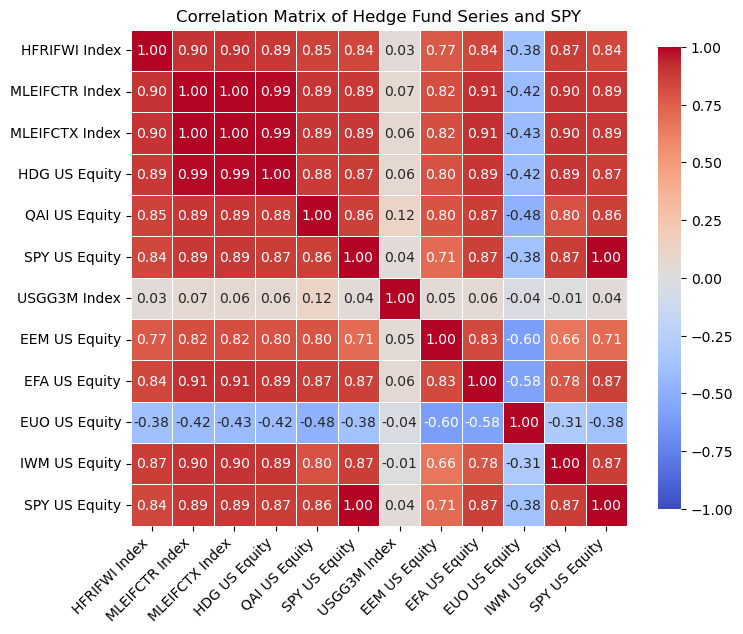

In [62]:

fig, ax = plt.subplots(figsize=(8, 8))
ax = plot_correlation_matrix(pd.concat([hf_series, mer_factors, spy], axis=1).corr(), ax=ax)
ax.set_title("Correlation Matrix of Hedge Fund Series and SPY");

## 6.

Replicate HFRI with the six factors listed on the "merrill factors" tab. Include a constant, and run the unrestricted regression,

$\newcommand{\hfri}{\text{hfri}}$
$\newcommand{\merr}{\text{merr}}$

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{\merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\hat{r}^{\hfri}_{t} &= \hat{\alpha}^{\merr} + x_{t}^{\merr}\hat{\beta}^{\merr}
\end{align}$$

Note that the second equation is just our notation for the fitted replication.

a. Report the intercept and betas.
b. Are the betas realistic position sizes, or do they require huge long-short positions?
c. Report the R-squared.
d. Report the volatility of $\epsilon^{\merr}$, the tracking error.

In [60]:
with_int = calc_multivariate_regression(hf_series['HFRIFWI Index'], mer_factors).T
no_int = calc_multivariate_regression(hf_series['HFRIFWI Index'], mer_factors, intercept=False).T
regrs = pd.concat([with_int, no_int], axis=1)
regrs.columns = ["HFRI w/Intercept", "HFRI w/o Intercept"]
regrs

C:\Users\Gurjivan\AppData\Local\Temp\ipykernel_29412\2623372289.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary[f"{col} Beta"] = betas[i]
C:\Users\Gurjivan\AppData\Local\Temp\ipykernel_29412\2623372289.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary[f"{col} Beta"] = betas[i]


,HFRI w/Intercept,HFRI w/o Intercept
Alpha,0.014824,0.000000
R-Squared,0.839676,0.845162
SPY US Equity Beta,0.036483,0.050667
USGG3M Index Beta,0.146336,0.499336
EEM US Equity Beta,0.081611,0.080866
EFA US Equity Beta,0.084638,0.079146
EUO US Equity Beta,0.028806,0.031373
IWM US Equity Beta,0.145111,0.142651
Information Ratio,0.622478,0.000000
Tracking Error,0.023815,0.023908


## 7.

Let's examine the replication out-of-sample (OOS).

Starting with $t = 61$ month of the sample, do the following:

* Use the previous 60 months of data to estimate the regression equation. 
This gives time-t estimates of the regression parameters, $\tilde{\alpha}^{\merr}_{t}$ and $\tilde{\beta}^{\merr}_{t}$.

* Use the estimated regression parameters, along with the time-t regressor values, $x^{\merr}_{t}$, calculate the time-t replication value that is, with respect to the regression estimate, built "out-of-sample" (OOS).

$$\hat{r}^{\hfri}_{t} \equiv \tilde{\alpha}^{\merr} + (x_{t}^{\merr})'\tilde{\beta}^{\merr}$$

* Step forward to $t = 62$, and now use $t = 2$ through $t = 61$ for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.

How well does the out-of-sample replication perform with respect to the target?

C:\Users\Gurjivan\AppData\Local\Temp\ipykernel_29412\902395260.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary[coeff].append(regr.params[jdx])
C:\Users\Gurjivan\AppData\Local\Temp\ipykernel_29412\902395260.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = regr.params[0] + (regr.params[1:] @ oos_X)
C:\Users\Gurjivan\AppData\Local\Temp\ipykernel_29412\902395260.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

OOS-R-Squared: 80.43%


C:\Users\Gurjivan\AppData\Local\Temp\ipykernel_29412\902395260.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary[coeff].append(regr.params[jdx])
C:\Users\Gurjivan\AppData\Local\Temp\ipykernel_29412\902395260.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = regr.params[0] + (regr.params[1:] @ oos_X)
C:\Users\Gurjivan\AppData\Local\Temp\ipykernel_29412\902395260.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

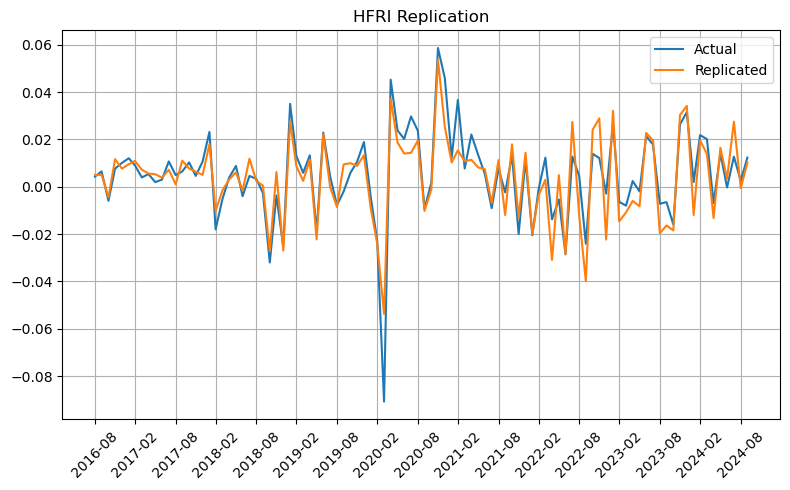

In [61]:
# Here, we use a new Python concept, called a defaultdict. This is a dictionary that
# automatically creates a new key if it doesn't exist. We can pass it a type in the constructor,
# and it will create a new key with that type if it doesn't exist and then we can interact with
# it as if it were a normal dictionary. So, since we have a list, we can do summary[key].append(value),
# without having to first do summary[key] = [].
from collections import defaultdict

hfri = hf_series[["HFRIFWI Index"]].copy()

summary = defaultdict(list)

for idx in range(60, len(hfri), 1):
    # Get the data for ML factors and HFRI
    X = mer_factors.iloc[idx - 60 : idx].copy()
    y = hfri.iloc[idx - 60 : idx, 0].copy()

    oos_y = hfri.iloc[idx, 0]
    oos_X = mer_factors.iloc[idx, :].copy()

    # Calculate the regression coefficients
    regr = sm.OLS(y, sm.add_constant(X), missing="drop").fit()

    for jdx, coeff in enumerate(regr.params.index):
        summary[coeff].append(regr.params[jdx])

    # Get predicted y by multiplying the coefficients by the X values and
    # adding the intercept
    y_pred = regr.params[0] + (regr.params[1:] @ oos_X)

    summary["Replicated"].append(y_pred)
    summary["Actual"].append(oos_y)


summary = pd.DataFrame(summary, index=hfri.index[60:])

# Calculate OOS R-Squared
oos_rsquared = (
    1 - (summary["Actual"] - summary["Replicated"]).var() / summary["Actual"].var()
)
print(f"OOS-R-Squared: {oos_rsquared:.2%}")

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(summary.index, summary["Actual"], label="Actual")
ax.plot(summary.index, summary["Replicated"], label="Replicated")
ax.grid(True)
ax.legend()

# Make ticklabels every 6 months and label them as %yyy-%mm
ax.set_xticks(summary.index[::6])
ax.set_xticklabels(
    [f"{i.year}-{i.month:02d}" for i in summary.index[::6]],
    rotation=45,
    horizontalalignment="center",
)

ax.set_title("HFRI Replication")
fig.tight_layout()

## 8.

We estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\check{r}^{\hfri}_{t} &= \check{\alpha}^{\merr} + x_{t}^{\merr}\check{\beta}^{\merr}
\end{align}$$

Report

* the regression beta. How does it compare to the estimated beta with an intercept, $\hat{\beta}^{\merr}$?

* the mean of the fitted value, $\check{r}^{\hfri}_{t}$. How does it compare to the mean of the HFRI?

* the correlations of the fitted values, $\check{r}^{\hfri}_{t}$ to the HFRI. How does the correlation compare to that of the fitted values with an intercept, $\hat{r}^{\hfri}_{t}$

Do you think Merrill and ProShares fit their replicators with an intercept or not?

In [ ]:
regr_int = sm.OLS(hfri, sm.add_constant(mer_factors), missing="drop").fit()
regr_no_int = sm.OLS(hfri, mer_factors, missing="drop").fit()

# Calculate the fitted mean
fitted_mean = (regr_int.params[0] + regr_int.params[1:] @ mer_factors.mean()) * 12
fitted_mean_no_int = (regr_no_int.params @ mer_factors.mean()) * 12

# Get hfri mean
hfri_mean = hfri.mean()  * 12

print(f'HFRI Mean: {hfri_mean[0]:.2%}')
print(f'Fitted Mean: {fitted_mean:.2%}')
print(f'Fitted Mean (no intercept): {fitted_mean_no_int:.2%}')

display(regrs)